In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rn


def plot_template(title, x_label, y_label, x_lim=None, y_lim=None):
    """Genera la plantilla para mantener consistencia en el formato
    de cada tabla generada.

    Args:
        title (string): Aplica titulos.
        x_label (float): Título de eje x.
        y_label (float): Título de eje y.
        x_lim ([float], optional): Límite en eje x. Defaults to None.
        y_lim ([float], optional): Límite en eje y. Defaults to None.

    Returns:
        object: Devuelve los objetos de la gráfica modificados con la
        plantilla requerida
    """
    fig, ax = plt.subplots(  # Tamaño de la figura en pulgadas (ancho, alto)
        figsize=(10, 6)
    )

    # Configuración de rótulos y unidades
    ax.set_title(title, fontsize=16)  # Título con tamaño de fuente
    ax.set_xlabel(x_label, fontsize=14)  # Eje x con rótulo y unidades
    ax.set_ylabel(y_label, fontsize=14)  # Eje y con rótulo y unidades

    # Configuración de la escala y las dimensiones
    if x_lim is not None:
        ax.set_xlim(x_lim)  # Limitar el eje x
    if y_lim is not None:
        ax.set_ylim(y_lim)  # Limitar el eje y

    ax.grid(True, which="both", linestyle="--", alpha=0.7)  # Añadir una cuadrícula

    fig.tight_layout()  # Ajusta los elementos para que no se solapen

    return (  # Devolver las figuras y ejes para más modificaciones si es necesario
        fig,
        ax,
    )


# test
if False:
    x = np.linspace(0, 10, 100)
    fig, ax = plot_template("This is a test", "X label", "Y label", [0, 10], [-1, 1])
    ax.scatter(x, [np.sin(i) for i in x], marker="+", color="red")

## Tarea: Modelo climático


### Problema


La probabilidad de que llueva (en Bogotá) crece linealmente desde cero a partir de las 6 am hasta tomar su máximo
a las 2 pm. Luego decrece hasta llegar a cero a las 6 pm.


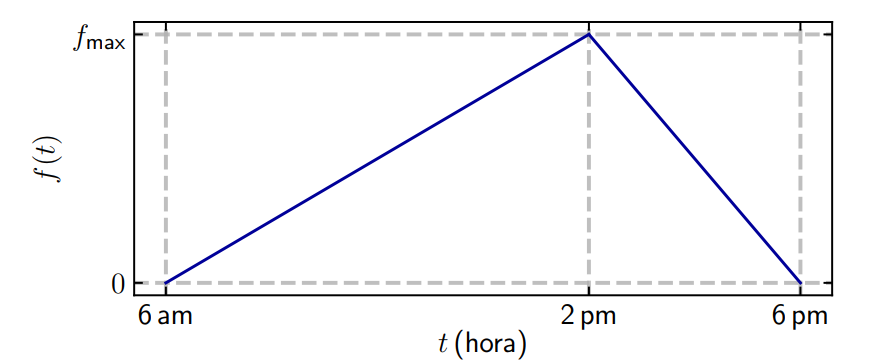


### Preguntas


#### 1. **Densidad de probabilidad**

Resolvemos primero el máximo para este problema utilizando geometría.

$$\text{area} = \frac{12 f_{max}}{2} = 1 \quad \Leftrightarrow \quad f_{max} = \frac{1}{6}$$

Luego, definimos esta función $P$ de _pdf_ como:

$$P(x) = \left\{ \begin{array}{lcc} 0 & si & x < 6 \\  (1/48) x - (3/24) & si & 6 \leq x \leq 14 \\  -(1/24) x + (3/4) & si & 14 < x \leq 18 \\  0 & si & x > 18 \end{array} \right. $$

Se define el objeto `prob_lluvia(periodo)` para definir un estado general de lo relacionado con el problema, tanto su _pdf_ con `P(x)`, las funciones que definen la probabilidad `.integral(hora)` y `.promedio(hora)`.


In [2]:
class model_rain:
    """Genera el objeto modelo de probabilidad de lluvia, inicializa los parámetros,
    genera la lista de horas debida y toma la función de densidad de probabilidad y
    la discretiza.
    """

    def __init__(self, period):
        """Se inicializan las variables y se establece la particion horas.

        Args:
            periodo (int, float): El periodo en el cuál se toman las particiones del tiempo.
        """

        self.period = period
        self.begin = 6  # hora inicial
        self.end = 18  # hora final
        self.N = 1  # Normalización.
        self.f_max = self.N / 6  # Máximo de probabilidad.
        self.sum_prob = 0  # Es la suma de probabilidades para normalizar

        # Paso
        self.step = int((self.end - self.begin) / self.period) + 1
        # Partición
        self.hours = np.linspace(self.begin, self.end, num=self.step)

    def PDF(self, x):
        """
        Función de densidad de probabilidad del modelo de la lluvia dado como
        función.

        Parameters:
        x (float): Variable aleatoria.

        Returns:
        float: probabilidad del punto.
        """
        if x < 6:
            return 0
        elif 6 <= x <= 14:
            return ((1 / 8) * x - (3 / 4)) * self.f_max
        elif 14 < x <= 18:
            return (-(1 / 4) * x + (9 / 2)) * self.f_max
        elif x > 18:
            return 0

    def cell(self, hour):
        """
        Devuelve el valor discretizado de la hora, haciendo una función piso
        para según la partición que se tenga y con una tolerancia de 1e-4.

        Parameters:
        hora (float): Variable de tiempo hora.

        Returns:
        float: Valor discretizado o 0 si no lo encontró.
        """
        for discreet_hour in self.hours:
            if (
                hour >= discreet_hour
                and hour < (discreet_hour + self.period)
                and not (np.isclose(hour, discreet_hour + self.period, atol=1e-4))
            ):
                return discreet_hour
        return 0

    def prob_integrating(self, hour):
        """Encuentra la probabilidad de la distribución discretizada a través del
        proceso de encontrar el área por trapecio

        Parameters:
        hora (float): Variable de tiempo como hora absoluta (militar).

        Returns:
        float: Probabilidad sin normalizar.
        """
        if hour < self.begin or hour > self.end:
            return 0
        hour = self.cell(hour)
        return self.period * (self.PDF(hour) + self.PDF(hour + self.period)) / 2

    def prob_averaging(self, hour):
        """Toma la hora absoluta (0-24 horas) y devuelve la probabilidad
        como media entre la función discretizada por el periodo.

        Args:
            hour (float): Variable de tiempo como hora absoluta (militar).

        Returns:
            float: Probabilidad sin normalizar.
        """
        if hour < self.begin or hour > self.end:
            return 0
        hour = self.cell(hour)
        return self.PDF(hour + self.period / 2)  # Promedio valores

    def prob_integrating_norm(self, hour):
        """Encuentra la probabilidad de la distribución discretizada a través del
        proceso de encontrar el área por trapecio normalizada.

        Args:
            hour (float): Variable de tiempo como hora absoluta (militar).

        Returns:
            float: Probabilidad normalizada.
        """
        return self.prob_integrating(hour) * (
            self.N / np.sum([self.prob_integrating(h) for h in self.hours])
        )

    def prob_averaging_norm(self, hour):
        """Toma la hora absoluta (0-24 horas) y devuelve la probabilidad
        como media entre la función discretizada por el periodo.

        Args:
            hour (float): Variable de tiempo como hora absoluta (militar).

        Returns:
            float: Probabilidad normalizada.
        """
        return self.prob_averaging(hour) * (
            self.N / np.sum([self.prob_averaging(h) for h in self.hours])
        )


# test
if True:
    model = model_rain(period=0.1)
    print(
        f"""
        Probabilidad: {model.prob_integrating(12)} 
        Probabilidad total promedio: {np.sum([model.prob_averaging_norm( hour ) for hour in model.hours]):.4f}
        Probabilidad total integral: {np.sum([model.prob_integrating_norm( hour ) for hour in model.hours]):.4f}
    """
    )

# [model.promedio(hora) - model.integral(hora) for hora in model.horas]


        Probabilidad: 0.012604166666666666 
        Probabilidad total promedio: 1.0000
        Probabilidad total integral: 1.0000
    


Se comprueba entonces que:

- Las funciones de probabilidad están normalizadas a 1.
- Las diferencias entre las formas de tomar la probabilidad son despreciables.


#### 2. **Obtener $f_{max}$**

Cómo se indicó en el punto previo, se resolvió tomando geométricamente el área y resolviendo el punto máximo para que la función de probabilidad fuera normalizada a 1. Como se sugiere también, dado que $f_{max}$ es el carácter que provee a la función la normalizacion, que se pueda generalizar como:

$$\text{area} = \frac{12 f_{max}}{2} = N \quad \Leftrightarrow \quad f_{max} = \frac{N}{6}$$

Luego, definimos esta función $P$ de _pdf_ como:

$$P(x) = \left\{ \begin{array}{lcc} 0 & si & x < 6 \\  f_{max}((1/8) x - (3/4)) & si & 6 \leq x \leq 14 \\  f_{max}(-(1/4) x + (9/2)) & si & 14 < x \leq 18 \\  0 & si & x > 18 \end{array} \right. $$

Podemos despejar la normalización para tenerla como parámetro en nuestro objeto `prob_lluvia` y de esa manera generalizarlo aún más.


#### 3. Gráficas y Función Acumulativa


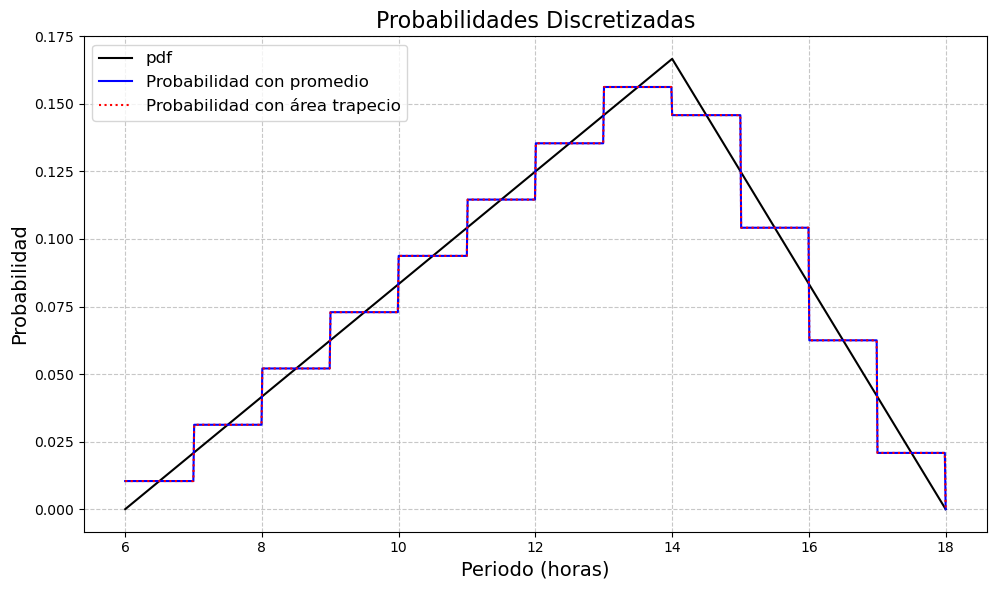

In [ ]:
model = model_rain(1)

# Plottting
fig, ax = plot_template(
    title="Probabilidades Discretizadas",
    x_label="Periodo (h)",
    y_label="Probabilidad",
)

hours = model.hours  # steps in the cell partition
steps = np.linspace(min(hours), max(hours), 1000)

"""Graficar función de densidad de probabilidad (PDF)"""
ax.plot(steps, [model.PDF(x) for x in steps], color="black", label="pdf")

"""Gráficar probabilidad con el método del punto medio."""
ax.plot(
    steps,
    [model.prob_averaging_norm(x) for x in steps],
    color="blue",
    label="Probabilidad con promedio",
)

"""Graficar probabilidad con el método de la 'integración'"""
ax.plot(
    steps,
    [model.prob_integrating_norm(x) for x in steps],
    ls="dotted",
    color="red",
    label="Probabilidad con área trapecio",
)

# Añadir leyenda para más claridad
ax.legend(fontsize=12)

# Mostrar el gráfico
plt.show()

Para la función acumulativa, se tiene en cuenta que se acumularan los valores de la probablidad. Se genera la función acumulativa $F$ y se grafica a continuación:


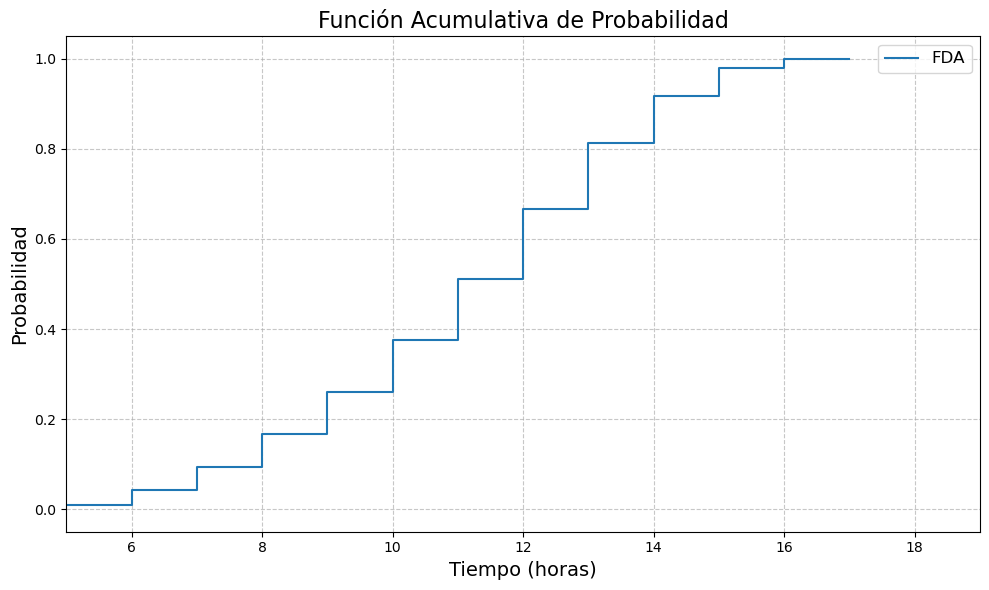

In [ ]:
def FDA(model):
    """Se genera la Función Acumulativa de Probabilidad (FDA)"""

    FDA = [0]
    hours = [0]
    sum = 0

    for hour in model.hours:

        sum += model.prob_integrating_norm(hour)
        FDA.append(sum)
        hours.append(hour)

    FDA.pop(), hours.pop()
    FDA = np.array(FDA)
    hours = np.array(hours)
    return FDA, hours


# Gráfica de la función Acumulativa.
fig, ax = plot_template(
    title="Función Acumulativa de Probabilidad",
    x_label="Tiempo (horas)",
    y_label="Probabilidad",
    x_lim=[5, 19],
)

FDA, hours = FDA(model)


ax.plot(hours, FDA, label="FDA", ds="steps")
# Añadir leyenda para más claridad


ax.legend(fontsize=12)


# Mostrar el gráfico
plt.show()


# test
if False:
    print(np.column_stack((FDA, hours)))

#### 4. Experimento


Se genera el experimento en historias (eventos) aleatorios con el método Montecarlo estudiado. Se genera bajo la plantilla del ejercicio propuesto por el profesor.


In [ ]:
class experiment:
    """Se genera el obeto que tomará al modelo y lo procesará con el método Montecarlo,
    se especificarán las variables del modelo bajo el experimento.
    """

    def __init__(self, model):
        self.model = model
        self.days_rain = 0
        self.days_not_rain = 0
        self.dim_PDF = len(model.hours)  # dimensión de la densidad de probabilidad.
        self.histogram = np.array([0] * self.dim_PDF)

    def always_rains(self, days):
        self.histogram = np.zeros(self.dim_PDF)
        success = 0
        for event in range(days):
            r = rn.random()
            for case in np.arange(1, self.dim_PDF):
                if r >= FDA[case - 1] and r < FDA[case]:
                    success = case
                    break
            self.histogram[success] += 1
        return self.histogram

Aquí veremos comparados 3 experimentos para verificar.


<function matplotlib.pyplot.show(close=None, block=None)>

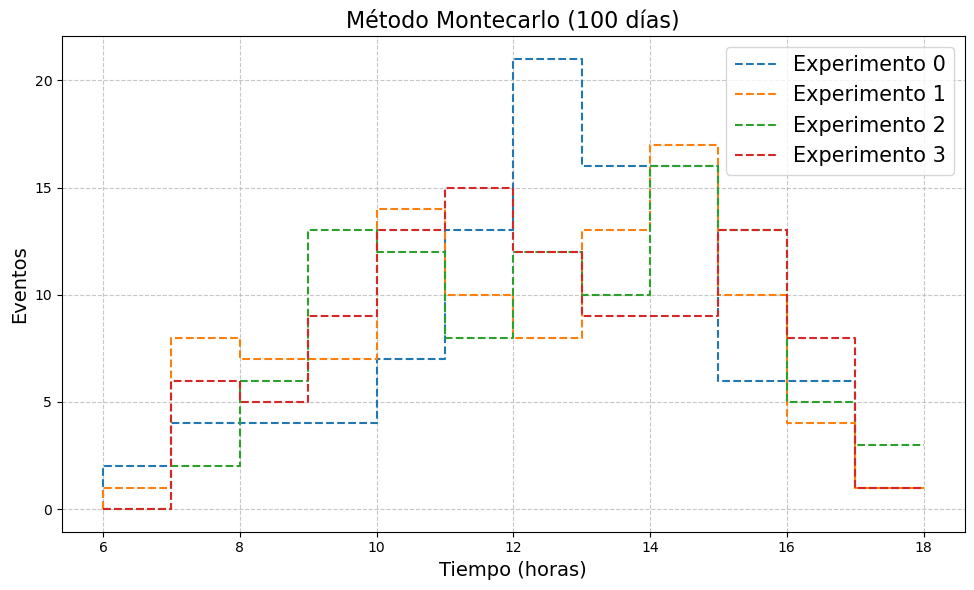

In [ ]:
days = 100
experiments = 4

# Generates 3 experiments to compare
exp = [experiment(model) for i in range(experiments)]

# Configure plot
fig, ax = plot_template(
    title=f"Método Montecarlo ({days} días)",
    x_label="Tiempo (horas)",
    y_label="Eventos",
)
# Plotting
for i in range(experiments):
    ax.plot(
        model.hours,
        exp[i].always_rains(days),
        ds="steps",
        label=f"Experimento {i}",
        ls="--",
    )
# Something left
ax.legend(fontsize=15)
plt.show

Pruebe cambiando el valor de `days` para cada requerido valor:

- 30
- 365
- 1000
- $10^6$


<function matplotlib.pyplot.show(close=None, block=None)>

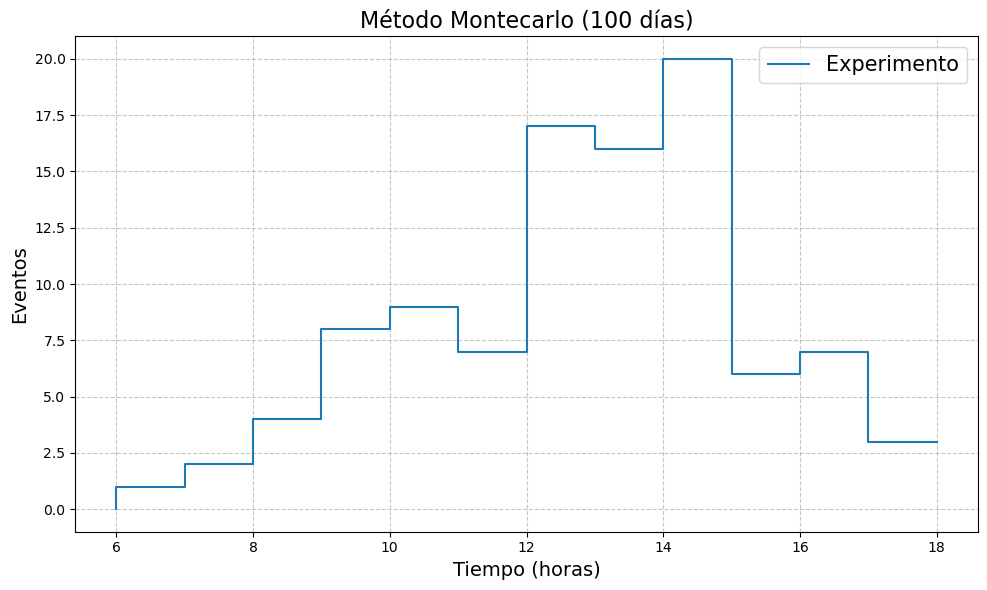

In [ ]:
# Ingrese el número de días
days = 100

# Inicialización
days = int(days)
experiments = 1

# Generates 3 experiments to compare
exp = [experiment(model) for i in range(experiments)]

# Configure plot
fig, ax = plot_template(
    title=f"Método Montecarlo ({days} días)",
    x_label="Tiempo (horas)",
    y_label="Eventos",
)
ax.plot(model.hours, exp[0].always_rains(days), ds="steps", label=f"Experimento")

# Last configuration
ax.legend(fontsize=15)
plt.show

#### 5. Verificar


(a) Se verifica que el comportamiento es como se desea determinar solapando cada gráfica requerida.


<function matplotlib.pyplot.show(close=None, block=None)>

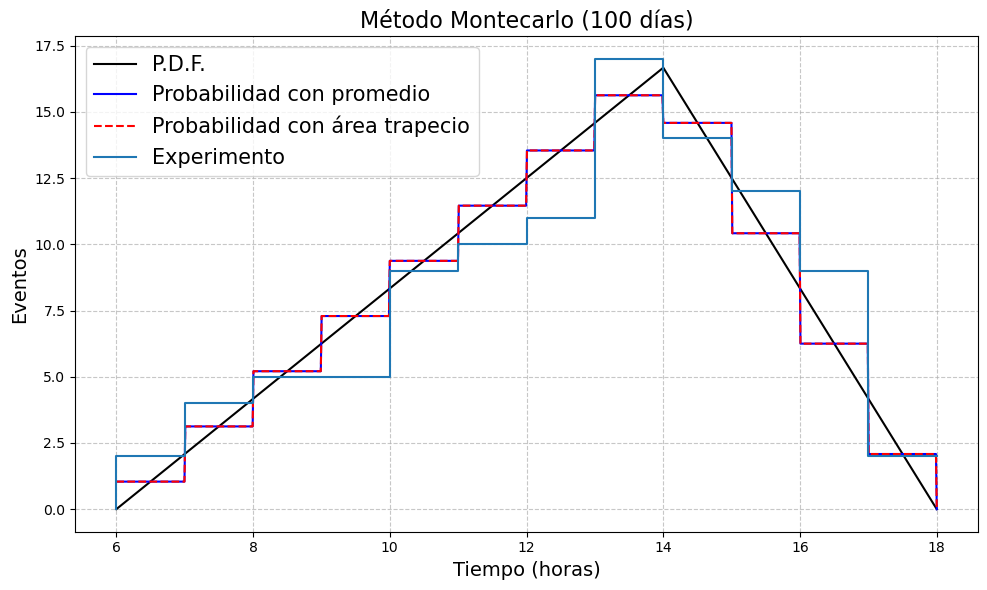

In [83]:
# Inicialización
days = int(100)
experiments = 1

# Generates 3 experiments to compare
exp = experiment(model)

# Configure plot
fig, ax = plot_template(
    title=f"Método Montecarlo ({days} días)",
    x_label="Tiempo (horas)",
    y_label="Eventos",
)
x_vals = np.linspace(min(model.hours), max(model.hours), 1000)
# Teórico
ax.plot(x_vals, [model.PDF(i) * days for i in x_vals], color="black", label="P.D.F.")
ax.plot(
    x_vals,
    [model.prob_averaging_norm(i) * days for i in x_vals],
    color="blue",
    label="Probabilidad con promedio",
    ls="-",
)
ax.plot(
    x_vals,
    [model.prob_integrating_norm(i) * days for i in x_vals],
    color="red",
    label="Probabilidad con área trapecio",
    ls="--",
)

# Experimental
ax.plot(model.hours, exp.always_rains(days), ds="steps", label=f"Experimento")

# Last configuration
ax.legend(fontsize=15)
plt.show

**(b)** Para comparar los resultados, se escala proporcional el número de eventos se prueben, dado que la probabilidad toma en cuenta la proporción de la población que se va a medir tan solo hace falta multiplicarlos como `pl.promedio(horas) * eventos` visto anteriormente en el código.


#### 6. ¿Y si puede no llover?

Suponemos que en cada día hay una probabilidad del 70% de que sí llueva, equivalente a `p_lluvia = 0.7`. Se simula a través del código con la sentencia `if` como fue sugerido, heredando la clase principal con una nueva función `sometimes_rains`.


In [84]:
class experiment_changed(experiment):
    def __init__(self, model):
        super().__init__(model)

    def sometimes_rain(self, days, probability_rains):
        self.days_not_rain = 0
        self.days_rain = 0
        self.histogram = np.zeros(self.dim_PDF)
        success = 0
        for event in range(days):
            r = rn.random()
            if r < probability_rains:
                self.days_rain += 1
                r = rn.random()
                for case in np.arange(1, self.dim_PDF):
                    if r >= FDA[case - 1] and r < FDA[case]:
                        success = case
                        break
                self.histogram[success] += 1
            else:
                self.days_not_rain += 1
        return self.histogram


# Test
if False:
    exp = experiment_changed(model)
    x = exp.sometimes_rain(100, 0.7)
    y = exp.always_rains(100)
    print(np.array(x) - np.array(y), sep="\n")

#### 7. Simular para 30 y 100 días

Se generan las simulaciones para los días con la correspondiente gráfica


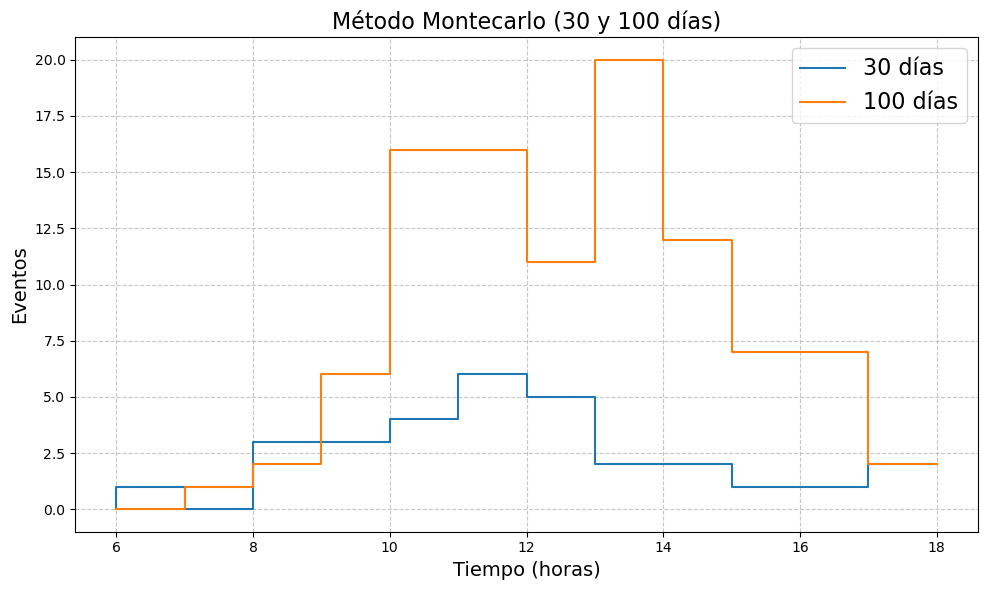

In [85]:
exp = experiment_changed(model)

# Configure plot
fig, ax = plot_template(
    title=f"Método Montecarlo (30 y 100 días)",
    x_label="Tiempo (horas)",
    y_label="Eventos",
)
# Plotting
ax.plot(model.hours, exp.always_rains(30), ds="steps", label=f"30 días")
ax.plot(model.hours, exp.always_rains(100), ds="steps", label=f"100 días")
# last
ax.legend(fontsize=16)
plt.show()

#### 8. Verificar días.

Aquí podemos verificar sencillamente con una impresión de la variable interna que siempre nos da el informe de los días, basta con generar el experimento y llamar a las variables internas que lo validan. En este ejemplo serán 100 días.


In [86]:
exp = experiment_changed(model)
exp.sometimes_rain(100, 0.7)

print(
    f"""
      Sí llovió: {exp.days_rain}
      No llovió: {exp.days_not_rain} 
      Total = {exp.days_rain + exp.days_not_rain}
"""
)


      Sí llovió: 65
      No llovió: 35 
      Total = 100



#### 9. Verificar distribución

Verifique en cada caso que el experimento sí siguió la distribución predefinida. A través de la gráfica observaremos la misma distribución con la función PDF proporcional a la probabilidad de llover de 70%.


<function matplotlib.pyplot.show(close=None, block=None)>

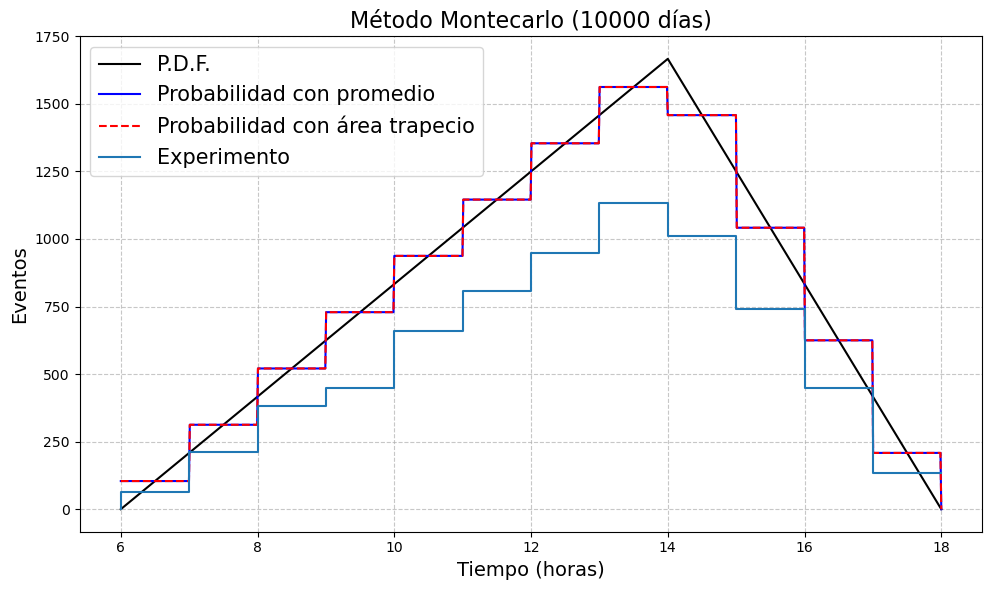

In [ ]:
# Inicialización
days = int(10000)
experiments = 1
prob_rains = 0.7

# Generates 3 experiments to compare
exp = experiment_changed(model)

# Configure plot
fig, ax = plot_template(
    title=f"Método Montecarlo ({days} días)",
    x_label="Tiempo (horas)",
    y_label="Eventos",
)
x_vals = np.linspace(min(model.hours), max(model.hours), 1000)
# Teórico
ax.plot(x_vals, [model.PDF(i) * days for i in x_vals], color="black", label="P.D.F.")
ax.plot(
    x_vals,
    [model.prob_averaging_norm(i) * days for i in x_vals],
    color="blue",
    label="Probabilidad con promedio",
    ls="-",
)
ax.plot(
    x_vals,
    [model.prob_integrating_norm(i) * days for i in x_vals],
    color="red",
    label="Probabilidad con área trapecio",
    ls="--",
)

# Experimental
ax.plot(
    model.hours, exp.sometimes_rain(days, prob_rains), ds="steps", label=f"Experimento"
)

# Last configuration
ax.legend(fontsize=15)
plt.show